# Pre-processing

In [3]:
import h5py
import json
import math

### Extract I3D features 

In [15]:
!python ../extract_frames_from_videos.py --fps 1 -x 256 -y 256 -i E:/annotated_dataset/videos E:/annotated_dataset/frames --num_workers 0 --write

reading ffprobe info of 75 videos...
Reloaded 75 videos from ffprobe results
75 videos in ffprobe infos. 75 files to process.
Durations (sec): min 38.000, max 647.582, avg 220.983, std 127.376

-------------------- formats_x
  347   400   453   507   560   613   667   720   773   827   880   933   987  1040  1093  1147  1200  1253  1307  1360  1413  1467  1520  1573  1627  1680  1733  1787  1840  1893
    1     0     0     2     1     1     2     0     0     0     1     0     1     0     0     0     0     0     1     0     0     0     0     0     0     0     0     0     0     1


~      6 tasks remaining...:  62%|###############         | 10/16 [00:25<00:14,  2.39s/it]



-------------------- formats_y
  254   282   310   338   366   394   422   450   478   506   534   562   590   618   646   674   702   730   758   786   814   842   870   898   926   954   982  1010  1038  1066
    1     1     0     1     3     0     0     0     2     0     0     0     0     0     0     0     0     2     0     0     0     0     0     0     0     0     0     0     0     1
-------------------- ratio_list
    1     1     1     1     1     1     1     1     1     1     1     2     2     2     2     2     2     2     2     2     2     2     2     2     2     2     2     2     2     2
    1     0     0     0     0     0     0     0     0     0     0     1     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     3
-------------------- fps_list
   15    16    16    17    17    18    18    19    19    20    20    21    21    22    22    23    23    24    24    25    25    26    26    27    27    28    28    29    29    30
    1 

~      0 tasks remaining...: 100%|########################| 16/16 [00:58<00:00,  3.68s/it]
'stty' is not recognized as an internal or external command,
operable program or batch file.


In [17]:
!python ../extract_100m_features.py E:/annotated_dataset/frames E:/annotated_dataset/video_feat_100m12.h5 --batch_size 16 --kernel 16 --stride 16

Load model...
Assuming frames at 16 FPS and 256x256 resolution in E:\annotated_dataset\frames. Load frames
Checking E:\annotated_dataset\frames for frames
Found 3 videos with 52240 frames total
Appending to file E:\annotated_dataset\video_feat_100m12.h5



Checking frames: 100%|##########| 6/6 [00:06<00:00,  1.12s/it]

  0%|          | 0/3 [00:00<?, ?it/s]Traceback (most recent call last):
  File "C:\Users\Msc 2\Desktop\Video-Text Summarization\Codes\coot-videotext-master\extract_100m_features.py", line 520, in <module>
    main()
  File "C:\Users\Msc 2\anaconda3\lib\site-packages\torch\utils\_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "C:\Users\Msc 2\Desktop\Video-Text Summarization\Codes\coot-videotext-master\extract_100m_features.py", line 100, in main
    frames = frames_loader.get_frames(data_id)
  File "C:\Users\Msc 2\Desktop\Video-Text Summarization\Codes\coot-videotext-master\extract_100m_features.py", line 48, in get_frames
    stacked_frames = th.stack(frames)  # shape (len_video, 3, h, w)
RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 12037914624 bytes.

  0%|         

### Merge h5s

In [29]:
listofh5s = ['video_feat_100m.h5', 'video_feat_100m2.h5', 'video_feat_100m3.h5', 'video_feat_100m4.h5', 'video_feat_100m5.h5', 'video_feat_100m6.h5',  'video_feat_100m8.h5', 'video_feat_100m9.h5', 'video_feat_100m10.h5', 'video_feat_100m11.h5', 'video_feat_100m12.h5']

In [31]:
import h5py
with h5py.File('E:/annotated_dataset/trial.h5', 'a') as d:
    for file in listofh5s:
        print(file)
        with h5py.File('E:/annotated_dataset/'+file, 'r') as f:
            for key in f.keys():
                # print(key)
                d.create_dataset(key, data=f[key][()])

video_feat_100m.h5
video_feat_100m2.h5
video_feat_100m3.h5
video_feat_100m4.h5
video_feat_100m5.h5
video_feat_100m6.h5
video_feat_100m8.h5
video_feat_100m9.h5
video_feat_100m10.h5
video_feat_100m11.h5
video_feat_100m12.h5


### Produce Segments

In [8]:

def calc_scatters(K):
    """
    Calculate scatter matrix:
    scatters[i,j] = {scatter of the sequence with starting frame i and ending frame j}
    """
    n = K.shape[0]
    K1 = np.cumsum([0] + list(np.diag(K)))
    K2 = np.zeros((n+1, n+1))
    K2[1:, 1:] = np.cumsum(np.cumsum(K, 0), 1); # TODO: use the fact that K - symmetric

    scatters = np.zeros((n, n))

    diagK2 = np.diag(K2)

    i = np.arange(n).reshape((-1,1))
    j = np.arange(n).reshape((1,-1))
    scatters = (K1[1:].reshape((1,-1))-K1[:-1].reshape((-1,1))
                - (diagK2[1:].reshape((1,-1)) + diagK2[:-1].reshape((-1,1)) - K2[1:,:-1].T - K2[:-1,1:]) / ((j-i+1).astype(float) + (j==i-1).astype(float)))
    scatters[j<i]=0

    return scatters

def cpd_nonlin(K, ncp, lmin=1, lmax=100000, backtrack=True, verbose=True,
    out_scatters=None):
    """ Change point detection with dynamic programming
    K - square kernel matrix
    ncp - number of change points to detect (ncp >= 0)
    lmin - minimal length of a segment
    lmax - maximal length of a segment
    backtrack - when False - only evaluate objective scores (to save memory)
    Returns: (cps, obj)
        cps - detected array of change points: mean is thought to be constant on [ cps[i], cps[i+1] )
        obj_vals - values of the objective function for 0..m changepoints
    """
    m = int(ncp)  # prevent numpy.int64

    (n, n1) = K.shape
    assert(n == n1), "Kernel matrix awaited."

    assert(n >= (m + 1)*lmin)
    assert(n <= (m + 1)*lmax)
    assert(lmax >= lmin >= 1)

    if verbose:
        #print "n =", n
        print("Precomputing scatters...")
    J = calc_scatters(K)

    if out_scatters != None:
        out_scatters[0] = J

    if verbose:
        print("Inferring best change points...")
    # I[k, l] - value of the objective for k change-points and l first frames
    I = 1e101*np.ones((m+1, n+1))
    I[0, lmin:lmax] = J[0, lmin-1:lmax-1]

    if backtrack:
        # p[k, l] --- "previous change" --- best t[k] when t[k+1] equals l
        p = np.zeros((m+1, n+1), dtype=int)
    else:
        p = np.zeros((1,1), dtype=int)

    for k in range(1,m+1):
        for l in range((k+1)*lmin, n+1):
            tmin = max(k*lmin, l-lmax)
            tmax = l-lmin+1
            c = J[tmin:tmax,l-1].reshape(-1) + I[k-1, tmin:tmax].reshape(-1)
            I[k,l] = np.min(c)
            if backtrack:
                p[k,l] = np.argmin(c)+tmin

     # Collect change points
    cps = np.zeros(m, dtype=int)

    if backtrack:
        cur = n
        for k in range(m, 0, -1):
            cps[k-1] = p[k, cur]
            cur = cps[k-1]

    scores = I[:, n].copy()
    scores[scores > 1e99] = np.inf
    return cps, scores

In [9]:
import numpy as np
def cpd_auto(K, ncp, vmax, desc_rate=1, **kwargs):
    """Main interface
    
    Detect change points automatically selecting their number
        K       - kernel between each pair of frames in video
        ncp     - maximum ncp
        vmax    - special parameter
    Optional arguments:
        lmin     - minimum segment length
        lmax     - maximum segment length
        desc_rate - rate of descriptor sampling (vmax always corresponds to 1x)
    Note:
        - cps are always calculated in subsampled coordinates irrespective to
            desc_rate
        - lmin and m should be in agreement
    ---
    Returns: (cps, costs)
        cps   - best selected change-points
        costs - costs for 0,1,2,...,m change-points
        
    Memory requirement: ~ (3*N*N + N*ncp)*4 bytes ~= 16 * N^2 bytes
    That is 1,6 Gb for the N=10000.
    """
    m = ncp
    (cpsx, scores) = cpd_nonlin(K, m, backtrack=False, **kwargs)
    
    N = K.shape[0]
    N2 = N*desc_rate  # length of the video before subsampling
    
    penalties = np.zeros(m+1)
    # Prevent division by zero (in case of 0 changes)
    ncp = np.arange(1, m+1)
    penalties[1:] = (vmax*ncp/(2.0*N2))*(np.log(float(N2)/ncp)+1)
    
    costs = scores/float(N) + penalties
    m_best = np.argmin(costs)
    (cps, scores2) = cpd_nonlin(K, m_best, **kwargs)

    return (cps, costs)
    

# ------------------------------------------------------------------------------
# Extra functions (currently not used)

def estimate_vmax(K_stable):
    """K_stable - kernel between all frames of a stable segment"""
    n = K_stable.shape[0]
    vmax = np.trace(centering(K_stable)/n)
    return vmax


def centering(K):
    """Apply kernel centering"""
    mean_rows = np.mean(K, 1)[:, np.newaxis]
    return K - mean_rows - mean_rows.T + np.mean(mean_rows)


def eval_score(K, cps):
    """ Evaluate unnormalized empirical score
        (sum of kernelized scatters) for the given change-points """
    N = K.shape[0]
    cps = [0] + list(cps) + [N]
    V1 = 0
    V2 = 0
    for i in range(len(cps)-1):
        K_sub = K[cps[i]:cps[i+1], :][:, cps[i]:cps[i+1]]
        V1 += np.sum(np.diag(K_sub))
        V2 += np.sum(K_sub) / float(cps[i+1] - cps[i])
    return (V1 - V2)


def eval_cost(K, cps, score, vmax):
    """ Evaluate cost function for automatic number of change points selection
    K      - kernel between all frames
    cps    - selected change-points
    score  - unnormalized empirical score (sum of kernelized scatters)
    vmax   - vmax parameter"""
    
    N = K.shape[0]
    penalty = (vmax*len(cps)/(2.0*N))*(np.log(float(N)/len(cps))+1)
    return score/float(N) + penalty

In [32]:
def gen_cps(H5_FILE, key):
    with h5py.File(H5_FILE,'r') as d:
        X = d[key][()]

        n = X.shape[0]
        m = int(math.ceil(n/2.0))
        K1 = np.dot(X, X.T)
        cps1, scores1 = cpd_auto(K1, m, 0.05)
        cps1 = np.hstack((0, cps1, len(X)-1))

        begin_frames = cps1[:-1]
        end_frames = np.append(cps1[1:-1], len(X))
        
        cps1 = np.vstack((begin_frames, end_frames - 1)).T

        n_frame_per_seg = end_frames - begin_frames
        return cps1

In [5]:
with h5py.File('data/youcook2/video_feat_100m.h5') as f:
    vid_names = [key for key in f.keys()]
vid_names

['-esJrBWj2d8',
 '0tmA_C6XwfM',
 '37rzWOQsNIw',
 '3eYKfiOEJNs',
 '4wU_LUjG5Ic',
 '91IHQYk1IQM',
 '98MoyGZKHXc',
 'Air_Force_One',
 'AwmHb44_ouw',
 'Base jumping',
 'Bearpark_climbing',
 'Bhxk-O1Y7Ho',
 'Bike Polo',
 'Bus_in_Rock_Tunnel',
 'Car_railcrossing',
 'Cockpit_Landing',
 'Cooking',
 'EE-bNr36nyA',
 'EYqVtI9YWJA',
 'Eiffel Tower',
 'Excavators river crossing',
 'Fire Domino',
 'GsAD1KT1xo8',
 'HT5vyqe0Xaw',
 'Hl-__g2gn_A',
 'J0nA4VgnoCo',
 'JKpqYvAdIsw',
 'JgHubY5Vw3Y',
 'Jumps',
 'Kids_playing_in_leaves',
 'LRw_obCPUt0',
 'Notre_Dame',
 'NyBmCxDoHJU',
 'PJrm840pAUI',
 'Paintball',
 'Playing_on_water_slide',
 'RBCABdttQmI',
 'Saving dolphines',
 'Scuba',
 'Se3oxnaPsz0',
 'St Maarten Landing',
 'Statue of Liberty',
 'Uncut_Evening_Flight',
 'Valparaiso_Downhill',
 'VuWGsYPqAX8',
 'WG0MBPpPC6I',
 'WxtbjNsCQ8A',
 'XkqCExn6_Us',
 'XzYM3PfTM4w',
 'Yi4Ij2NM7U4',
 '_xMr-HKMfVA',
 'akI8YFjEmUw',
 'b626MiF1ew4',
 'byxOvuiIJV0',
 'car_over_camera',
 'eQu1rNs0an0',
 'gzDbaEs1Rlg',
 'i3wAGJ

In [33]:
meta= {}

with h5py.File('data/youcook2/GoogLenetFeats.h5') as df:
    for key in df.keys():
        vn = df[key]['video_name'][()].decode()
        if vn.split('.')[0] in vid_names:
            name = vn.split('.')[0]
            print(name)
            cps = gen_cps('data/youcook2/video_feat_100m.h5', name)
            fps = df[key]['fps'][()]
            duration = df[key]['duration'][()]
            timings = cps*16/fps
            segments = []
            zipped = zip(timings, cps)
            for (start, end), (s_frame, e_frame) in zipped:
                if s_frame>e_frame:
                    print('switch')
                    e_frame = s_frame
                    t = start
                    start = end
                    end = t
                    
                seg_dict = {"start_sec": start, "stop_sec": end,"start_frame":float(s_frame),"stop_frame":float(e_frame), "text": "_"}
                segments.append(seg_dict)
            clip_dict = {'data_key':name, 'duration_sec':duration, 'segments': segments, 'split':'val' }
            meta[name] = clip_dict
            
            

-esJrBWj2d8
Precomputing scatters...
Inferring best change points...
Precomputing scatters...
Inferring best change points...
AwmHb44_ouw
Precomputing scatters...
Inferring best change points...
Precomputing scatters...
Inferring best change points...
b626MiF1ew4
Precomputing scatters...
Inferring best change points...
Precomputing scatters...
Inferring best change points...
Base jumping
Precomputing scatters...
Inferring best change points...
Precomputing scatters...
Inferring best change points...
Bearpark_climbing
Precomputing scatters...
Inferring best change points...
Precomputing scatters...
Inferring best change points...
Bhxk-O1Y7Ho
Precomputing scatters...
Inferring best change points...
Precomputing scatters...
Inferring best change points...
Bike Polo
Precomputing scatters...
Inferring best change points...
Precomputing scatters...
Inferring best change points...
Bus_in_Rock_Tunnel
Precomputing scatters...
Inferring best change points...
Precomputing scatters...
Inferring be

In [34]:
meta.keys()

dict_keys(['-esJrBWj2d8', 'AwmHb44_ouw', 'b626MiF1ew4', 'Base jumping', 'Bearpark_climbing', 'Bhxk-O1Y7Ho', 'Bike Polo', 'Bus_in_Rock_Tunnel', 'byxOvuiIJV0', 'car_over_camera', 'Car_railcrossing', '0tmA_C6XwfM', 'Cockpit_Landing', 'Cooking', 'EE-bNr36nyA', 'Eiffel Tower', 'eQu1rNs0an0', 'Excavators river crossing', 'EYqVtI9YWJA', 'Fire Domino', '37rzWOQsNIw', 'GsAD1KT1xo8', 'gzDbaEs1Rlg', 'Hl-__g2gn_A', 'HT5vyqe0Xaw', 'i3wAGJaaktw', 'iVt07TCkFM0', 'J0nA4VgnoCo', 'jcoYJXDG9sw', 'JgHubY5Vw3Y', '3eYKfiOEJNs', 'JKpqYvAdIsw', 'Jumps', 'Kids_playing_in_leaves', 'kLxoNp-UchI', 'LRw_obCPUt0', 'Notre_Dame', 'NyBmCxDoHJU', 'oDXZc0tZe04', 'Paintball', 'paluma_jump', '4wU_LUjG5Ic', 'PJrm840pAUI', 'playing_ball', 'Playing_on_water_slide', 'qqR6AEXwxoQ', 'RBCABdttQmI', 'Saving dolphines', 'Scuba', 'Se3oxnaPsz0', 'St Maarten Landing', 'Statue of Liberty', '91IHQYk1IQM', 'sTEELN-vY30', 'uGu_10sucQo', 'Uncut_Evening_Flight', 'Valparaiso_Downhill', 'vdmoEJ5YbrQ', 'VuWGsYPqAX8', 'WG0MBPpPC6I', 'WxtbjNsCQ

In [35]:
with open("meta_all.json", "w") as outfile:
    json.dump(meta, outfile)

### Transnet Segments

In [13]:
a={}
with h5py.File('data/youcook2Trans/tvsumSegsWithoutScenes.h5') as f:
    for k  in f.keys():
        a[f[k+'/video_name'][()].decode().split('.')[0]]= k

In [18]:
Summe = ['Base jumping', 'Bearpark_climbing', 'Bearpark_climbing', 'Bus_in_Rock_Tunnel','Bike Polo', 'car_over_camera', 'Car_railcrossing', 'Cockpit_Landing',  'Cooking', 'Eiffel Tower', 'Excavators river crossing', 'Fire Domino', 'Jumps', 'Kids_playing_in_leaves','Notre_Dame', 'Paintball', 'paluma_jump', 'playing_ball', 'Playing_on_water_slide', 'Saving dolphines', 'Scuba', 'St Maarten Landing', 'Statue of Liberty', 'Uncut_Evening_Flight','Valparaiso_Downhill', 'Air_Force_One']
meta= {}

with h5py.File('data/youcook2Trans/tvsumSegsWithoutScenes.h5') as df, h5py.File('data/youcook2/GoogLenetFeats.h5') as t:
    for key in t.keys():
        vn = t[key]['video_name'][()].decode()
        if vn.split('.')[0] in vid_names:
            name = vn.split('.')[0]
            print(name)
            if name in Summe:
                continue
                
            cps = df[a[name]]['change_points']
            fps = t[key]['fps'][()]
            duration = t[key]['duration'][()]
            timings = cps/fps
            segments = []
            zipped = zip(timings, cps)
            s_frame = 0
            for (start, end), (_, e_frame) in zipped:
                e_frame=e_frame//16
                    
                seg_dict = {"start_sec": start, "stop_sec": end,"start_frame":float(s_frame),"stop_frame":float(e_frame), "text": "_"}
                segments.append(seg_dict)
                s_frame=e_frame+1
            clip_dict = {'data_key':name, 'duration_sec':duration, 'segments': segments, 'split':'val' }
            meta[name] = clip_dict

-esJrBWj2d8
AwmHb44_ouw
b626MiF1ew4
Base jumping
Bearpark_climbing
Bhxk-O1Y7Ho
Bike Polo
Bus_in_Rock_Tunnel
byxOvuiIJV0
car_over_camera
Car_railcrossing
0tmA_C6XwfM
Cockpit_Landing
Cooking
EE-bNr36nyA
Eiffel Tower
eQu1rNs0an0
Excavators river crossing
EYqVtI9YWJA
Fire Domino
37rzWOQsNIw
GsAD1KT1xo8
gzDbaEs1Rlg
Hl-__g2gn_A
HT5vyqe0Xaw
i3wAGJaaktw
iVt07TCkFM0
J0nA4VgnoCo
jcoYJXDG9sw
JgHubY5Vw3Y
3eYKfiOEJNs
JKpqYvAdIsw
Jumps
Kids_playing_in_leaves
kLxoNp-UchI
LRw_obCPUt0
Notre_Dame
NyBmCxDoHJU
oDXZc0tZe04
Paintball
paluma_jump
4wU_LUjG5Ic
PJrm840pAUI
playing_ball
Playing_on_water_slide
qqR6AEXwxoQ
RBCABdttQmI
Saving dolphines
Scuba
Se3oxnaPsz0
St Maarten Landing
Statue of Liberty
91IHQYk1IQM
sTEELN-vY30
uGu_10sucQo
Uncut_Evening_Flight
Valparaiso_Downhill
vdmoEJ5YbrQ
VuWGsYPqAX8
WG0MBPpPC6I
WxtbjNsCQ8A
XkqCExn6_Us
xmEERLqJ2kU
98MoyGZKHXc
xwqBXPGE9pQ
xxdtq8mxegs
XzYM3PfTM4w
Yi4Ij2NM7U4
z_6gVvQb2d0
_xMr-HKMfVA
Air_Force_One
akI8YFjEmUw


In [19]:
meta.keys()

dict_keys(['-esJrBWj2d8', 'AwmHb44_ouw', 'b626MiF1ew4', 'Bhxk-O1Y7Ho', 'byxOvuiIJV0', '0tmA_C6XwfM', 'EE-bNr36nyA', 'eQu1rNs0an0', 'EYqVtI9YWJA', '37rzWOQsNIw', 'GsAD1KT1xo8', 'gzDbaEs1Rlg', 'Hl-__g2gn_A', 'HT5vyqe0Xaw', 'i3wAGJaaktw', 'iVt07TCkFM0', 'J0nA4VgnoCo', 'jcoYJXDG9sw', 'JgHubY5Vw3Y', '3eYKfiOEJNs', 'JKpqYvAdIsw', 'kLxoNp-UchI', 'LRw_obCPUt0', 'NyBmCxDoHJU', 'oDXZc0tZe04', '4wU_LUjG5Ic', 'PJrm840pAUI', 'qqR6AEXwxoQ', 'RBCABdttQmI', 'Se3oxnaPsz0', '91IHQYk1IQM', 'sTEELN-vY30', 'uGu_10sucQo', 'vdmoEJ5YbrQ', 'VuWGsYPqAX8', 'WG0MBPpPC6I', 'WxtbjNsCQ8A', 'XkqCExn6_Us', 'xmEERLqJ2kU', '98MoyGZKHXc', 'xwqBXPGE9pQ', 'xxdtq8mxegs', 'XzYM3PfTM4w', 'Yi4Ij2NM7U4', 'z_6gVvQb2d0', '_xMr-HKMfVA', 'akI8YFjEmUw'])

In [22]:
with open("data/youcook2Trans/meta_all.json", "w") as outfile:
    json.dump(meta, outfile)

### Precompute text features

In [23]:
!python ../precompute_text.py youcook2Trans

******************** Loading model bert-base-uncased from transformers
Running model on device cpu
Maximum input length 512
Loading meta file of 0 MB
Took 0.0 seconds for 47.
Total 1529 average 32.53 max 101
******************** Loading and testing dataset.
key: -esJrBWj2d8

text: ['[CLS] _ [SEP]', '_ [SEP]', '_ [SEP]', '_ [SEP]', '_ [SEP]', '_ [SEP]', '_ [SEP]', '_ [SEP]', '_ [SEP]', '_ [SEP]', '_ [SEP]', '_ [SEP]', '_ [SEP]', '_ [SEP]', '_ [SEP]', '_ [SEP]', '_ [SEP]', '_ [SEP]', '_ [SEP]', '_ [SEP]', '_ [SEP]']

text_tokenized: [['[CLS]', '_', '[SEP]'], ['_', '[SEP]'], ['_', '[SEP]'], ['_', '[SEP]'], ['_', '[SEP]'], ['_', '[SEP]'], ['_', '[SEP]'], ['_', '[SEP]'], ['_', '[SEP]'], ['_', '[SEP]'], ['_', '[SEP]'], ['_', '[SEP]'], ['_', '[SEP]'], ['_', '[SEP]'], ['_', '[SEP]'], ['_', '[SEP]'], ['_', '[SEP]'], ['_', '[SEP]'], ['_', '[SEP]'], ['_', '[SEP]'], ['_', '[SEP]']]

tokens: tensor([ 101, 1035,  102, 1035,  102, 1035,  102, 1035,  102, 1035,  102, 1035,
         102, 1035,  102, 10

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

Compute total_words and max_words: 100%|##########| 47/47 [00:00<?, ?it/s]

compute text features: 100%|##########| 47/47 [00:04<00:00, 11.41it/s]


### Feature Retieval

In [27]:
!python ../train_retrieval.py -g paper2020 -e yc2_100m_coot -r valset --load_model provided_models/yc2_100m_coot.pth --reset --validate --save_embeddings --no_cuda

Source config: config\retrieval\paper2020\yc2_100m_coot.yaml
Results path:  experiments/retrieval/paper2020/yc2_100m_coot
    Change config: Set use_cuda to False.
Built metadata for val: 47 datapoints, 1529 segments. Expanded 1529 segments.
---------- Setup done!
Logger: 'trainlog' to experiments\retrieval\paper2020\yc2_100m_coot_valset1\logs\run_2023_04_14_21_07_37.log
 INFO Running on cuda: False, multi-gpu: False, gpus found: 0, fp16 amp: False.
 INFO Random seed: None
 INFO Loading model from checkpoint file provided_models/yc2_100m_coot.pth
Backward compatible loading for coot-videotext: net_video_local
Backward compatible loading for coot-videotext: net_video_global
Backward compatible loading for coot-videotext: net_text_local
Backward compatible loading for coot-videotext: net_text_global
batch.vid_feat torch.Size([47, 877, 512])



Validate epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\Msc 2\anaconda3\lib\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
Traceback (most recent call last):
  File "C:\Users\Msc 2\Desktop\Video-Text Summarization\Codes\coot-videotext-master\train_retrieval.py", line 100, in <module>
    main()
  File "C:\Users\Msc 2\Desktop\Video-Text Summarization\Codes\coot-videotext-master\train_retrieval.py", line 88, in main
    trainer.validate_epoch(val_loader, val_clips=cfg.val.val_clips, save_embs=args.save_embeddings)
  File "C:\Users\Msc 2\anaconda3\lib\site-packages\torch\utils\_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "C:\Users\Msc 2\Desktop\Video-Text Summarization\Codes\coot-videotext-master\coot\trainer_retrieval.py", line 367, in validate_epoch
    visua

### Create GT and User Summary File

In [43]:
with h5py.File('../../directory/Preprocessing/extracted_features/normal/merged.h5') as d, h5py.File('summaries.h5', 'a') as summh5:
    for key in d.keys():
        name = d[key]['video_name'][()].decode().split('.')[0]
        summh5.create_dataset(name+'/'+'gt_summary', data=d[key]['gt_summary'][()])
        summh5.create_dataset(name+'/'+'user_summary', data=d[key]['user_summary'][()])
        print(name)

Air_Force_One
playing_ball
Playing_on_water_slide
Base jumping
Saving dolphines
Scuba
St Maarten Landing
Statue of Liberty
Uncut_Evening_Flight
Valparaiso_Downhill
Bearpark_climbing
Eiffel Tower
Bike Polo
Bus_in_Rock_Tunnel
car_over_camera
Car_railcrossing
Cockpit_Landing
Cooking
AwmHb44_ouw
akI8YFjEmUw
i3wAGJaaktw
Bhxk-O1Y7Ho
Excavators river crossing
0tmA_C6XwfM
3eYKfiOEJNs
xxdtq8mxegs
WG0MBPpPC6I
Hl-__g2gn_A
Yi4Ij2NM7U4
37rzWOQsNIw
98MoyGZKHXc
LRw_obCPUt0
cjibtmSLxQ4
Fire Domino
b626MiF1ew4
XkqCExn6_Us
GsAD1KT1xo8
PJrm840pAUI
91IHQYk1IQM
RBCABdttQmI
z_6gVvQb2d0
fWutDQy1nnY
J0nA4VgnoCo
4wU_LUjG5Ic
Jumps
VuWGsYPqAX8
JKpqYvAdIsw
xmEERLqJ2kU
byxOvuiIJV0
_xMr-HKMfVA
WxtbjNsCQ8A
uGu_10sucQo
EE-bNr36nyA
Se3oxnaPsz0
gzDbaEs1Rlg
Kids_playing_in_leaves
oDXZc0tZe04
qqR6AEXwxoQ
EYqVtI9YWJA
eQu1rNs0an0
JgHubY5Vw3Y
iVt07TCkFM0
E11zDS9XGzg
NyBmCxDoHJU
kLxoNp-UchI
jcoYJXDG9sw
Notre_Dame
XzYM3PfTM4w
-esJrBWj2d8
HT5vyqe0Xaw
sTEELN-vY30
vdmoEJ5YbrQ
xwqBXPGE9pQ
Paintball
paluma_jump


In [29]:
a=[]
with h5py.File('../../directory/Preprocessing/extracted_features/normal/TVSum.h5', 'r') as d:
    for key in d.keys():
        a.append(d[key]['duration'][...])

In [33]:
import numpy as np
x=np.array(a)

C:\Users\Msc 2\AppData\Local\Temp\ipykernel_22476\2049710947.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, axlabel='duration (sec)', norm_hist=True)


<AxesSubplot:xlabel='duration (sec)', ylabel='Density'>

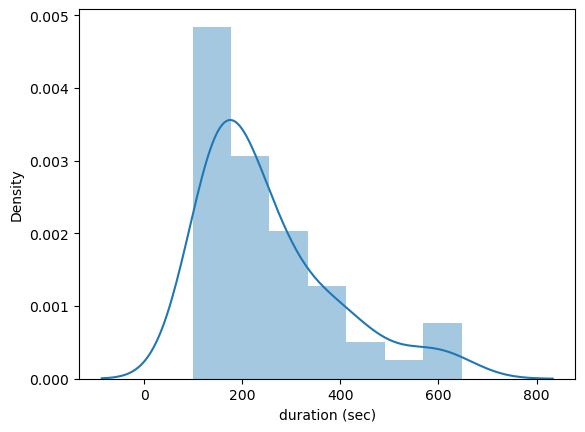

In [38]:
import seaborn as sns

sns.distplot(x, axlabel='duration (sec)', norm_hist=True)